## load video features

In [ ]:
import pickle
dbfile = open('/content/drive/MyDrive/Pickle_Data/video_features.pkl', 'rb')     
db = pickle.load(dbfile)

label_map_file = open('/content/drive/MyDrive/Pickle_Data/label_map.pkl', 'rb')
label_map = pickle.load(label_map_file)

In [ ]:
import tensorflow as tf
import keras
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import pickle
import numpy as np



In [ ]:
x_labels = db.keys()
x = []
y = []

for l in x_labels:
  x.append(db[l])
  y.append(label_map[l])


import numpy as np
x = np.array(x).astype('float32')
y = np.array(y)

In [ ]:
y = np.where(y==True, 1, 0)

In [ ]:
y_oh = tf.keras.utils.to_categorical(y)

In [ ]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train_vid, X_test_vid, y_train_vid, y_test_vid = train_test_split(x,y_oh, test_size=0.10, random_state=0)

In [ ]:
X_train_vid.shape

(621, 2048)

In [ ]:
y_train_vid.shape

(621, 2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train_vid = sc.fit_transform(X_train_vid)
X_test_vid = sc.transform(X_test_vid)


In [ ]:
def plot_graphs(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### NN for visual features (pytorch)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
train_inputs = torch.from_numpy(X_train)
train_outputs = torch.from_numpy(y_train)
test_inputs = torch.from_numpy(X_test)
test_outputs = torch.from_numpy(y_test)

In [ ]:
train_inputs

tensor([[1.5939, 0.5651, 0.3205,  ..., 0.5311, 0.2921, 0.1731],
        [0.5035, 0.8958, 0.2919,  ..., 0.5181, 0.5208, 0.4664],
        [1.3112, 0.2034, 0.2667,  ..., 0.5837, 0.3780, 0.1474],
        ...,
        [0.4112, 0.3439, 1.3493,  ..., 0.3436, 0.1552, 0.2368],
        [0.6354, 0.1746, 0.5362,  ..., 0.4959, 0.2926, 0.2626],
        [0.9946, 0.4731, 0.4669,  ..., 0.4894, 0.3516, 0.0844]])

In [ ]:
train_dataset = TensorDataset(train_inputs, train_outputs)
test_dataset = TensorDataset(test_inputs, test_outputs)

In [ ]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=True)

In [ ]:
from torch.nn.modules.activation import Sigmoid
class BasicNN(nn.Module):

    def __init__(self):
      super(BasicNN, self).__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(2048, 512),
          nn.ReLU(),
          nn.Linear(512, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32,1)
      )

    def forward(self, x):
      x = self.flatten(x)
      logits = self.linear_relu_stack(x)
      sigmoid = nn.Sigmoid()
      return sigmoid(logits)

In [ ]:
model = BasicNN().to(device)
print(model)

BasicNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
epochs = 1
optimizer = optim.Adam(model.parameters(), lr = 0.002)
criterion = nn.BCELoss()


In [ ]:
for _ in range(epochs):
  
  for x,y in train_loader:
    optimizer.zero_grad()
    x = x.to(device)
    y = torch.unsqueeze(y, 1)
    y = y.to(device)
    preds = model(x)
    print(preds)
    loss = criterion(y.float(), preds.float())
    loss.backward()
    optimizer.step()

    print(loss)



False

## tensorflow

In [ ]:
tf.keras.backend.clear_session()
vidmodel1 = tf.keras.models.Sequential()
vidmodel1.add(tf.keras.layers.Dense(512, input_shape=(2048,), activation="relu"))
vidmodel1.add(tf.keras.layers.Dense(256, activation="relu"))
vidmodel1.add(tf.keras.layers.Dense(64,  activation="relu"))
vidmodel1.add(tf.keras.layers.Dense(32, activation="relu"))
vidmodel1.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
vidmodel1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,199,010
Trainable params: 1,199,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
vidmodel1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
vidhistory1 = vidmodel1.fit(X_train_vid, y_train_vid, epochs=30, callbacks=[callback], validation_data=(X_test_vid, y_test_vid))

Epoch 1/30
20/20 [==============================] - 1s 23ms/step - loss: 0.7172 - accuracy: 0.4944 - val_loss: 0.6615 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 0s 12ms/step - loss: 0.6689 - accuracy: 0.5765 - val_loss: 0.6423 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 0s 14ms/step - loss: 0.6526 - accuracy: 0.6312 - val_loss: 0.6795 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 0s 13ms/step - loss: 0.6341 - accuracy: 0.6441 - val_loss: 0.6063 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 0s 12ms/step - loss: 0.6338 - accuracy: 0.6490 - val_loss: 0.6067 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 0s 13ms/step - loss: 0.5891 - accuracy: 0.6957 - val_loss: 0.6074 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 0s 14ms/step - loss: 0.5

In [ ]:
y_vid_pred1 = vidmodel1.predict(X_test_vid)
rep = classification_report(np.argmax(y_test_vid, axis=1),np.argmax(y_vid_pred1, axis=1) )
print(rep)

3/3 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.62      0.47      0.54        32
           1       0.62      0.76      0.68        37

    accuracy                           0.62        69
   macro avg       0.62      0.61      0.61        69
weighted avg       0.62      0.62      0.61        69



In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.argmax(y_test_vid, axis=1),np.argmax(y_vid_pred1, axis=1) )

0.6127533783783784

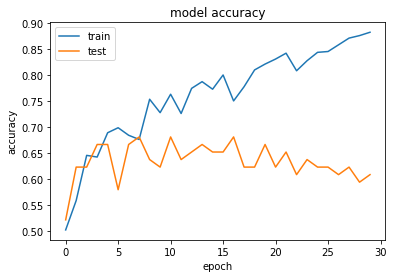

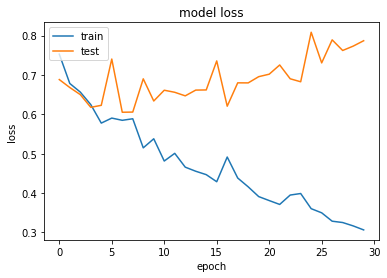

In [ ]:
plot_graphs(vidhistory1)

In [ ]:
vidmodel2 = tf.keras.models.Sequential()
vidmodel2.add(tf.keras.layers.Dense(512, input_shape=(2048,), activation="relu"))
vidmodel2.add(tf.keras.layers.Dense(256, activation="relu"))
vidmodel2.add(tf.keras.layers.Dense(32, activation="relu"))
vidmodel2.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
vidmodel2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 32)                8224      
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,188,706
Trainable params: 1,188,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vidmodel2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
vidhistory2 = vidmodel2.fit(X_train_vid, y_train_vid, epochs=30, callbacks=[callback], validation_data=(X_test_vid, y_test_vid))

Epoch 1/30
20/20 [==============================] - 1s 24ms/step - loss: 0.8177 - accuracy: 0.5250 - val_loss: 0.6692 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.5652 - val_loss: 0.6305 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 0s 12ms/step - loss: 0.6175 - accuracy: 0.6634 - val_loss: 0.7258 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 0s 13ms/step - loss: 0.6194 - accuracy: 0.6634 - val_loss: 0.7563 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 0s 12ms/step - loss: 0.6034 - accuracy: 0.6651 - val_loss: 0.6199 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 0s 15ms/step - loss: 0.5448 - accuracy: 0.7101 - val_loss: 0.5880 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 0s 15ms/step - loss: 0.5

In [ ]:
y_vid_pred2 = vidmodel2.predict(X_test_vid)
rep = classification_report(np.argmax(y_test_vid, axis=1),np.argmax(y_vid_pred2, axis=1) )
print(rep)

3/3 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.56      0.78      0.65        32
           1       0.71      0.46      0.56        37

    accuracy                           0.61        69
   macro avg       0.63      0.62      0.60        69
weighted avg       0.64      0.61      0.60        69



In [ ]:
roc_auc_score(np.argmax(y_test_vid, axis=1),np.argmax(y_vid_pred2, axis=1) )

0.6203547297297297

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(y_test_vid, axis=1),np.argmax(y_vid_pred2, axis=1) )

0.6086956521739131

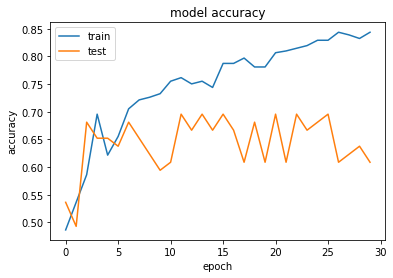

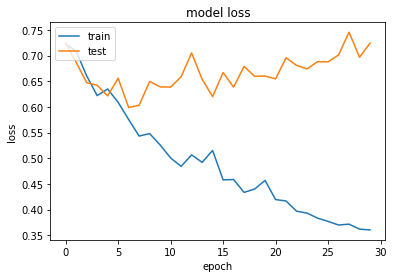

In [ ]:
plot_graphs(vidhistory2)

## Audio

In [ ]:
dbfile = open('/content/drive/MyDrive/Pickle_Data/audio_features.pkl', 'rb')     
db = pickle.load(dbfile)

label_map_file = open('/content/drive/MyDrive/Pickle_Data/label_map.pkl', 'rb')
label_map = pickle.load(label_map_file)

In [ ]:
x_labels = db.keys()
x = []
y = []

for l in x_labels:
  x.append(db[l])
  y.append(label_map[l])


import numpy as np
x = np.array(x).astype('float32')
y = np.array(y)

In [ ]:
y = np.where(y==True, 1, 0)
y_oh = tf.keras.utils.to_categorical(y)

In [ ]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train_aud, X_test_aud, y_train_aud, y_test_aud = train_test_split(x,y_oh, test_size=0.10, random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train_aud = sc.fit_transform(X_train_aud)
X_test_aud = sc.transform(X_test_aud)


In [ ]:
X_train_aud.shape

(621, 283)

In [ ]:
tf.keras.backend.clear_session()
audmodel1 = tf.keras.models.Sequential()
audmodel1.add(tf.keras.layers.Dense(128, input_shape=(283,), activation="relu"))
audmodel1.add(tf.keras.layers.Dense(32, activation="relu"))
audmodel1.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
audmodel1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
audhistory1 = audmodel1.fit(X_train_aud, y_train_aud, epochs=30, callbacks=[callback], validation_data=(X_test_aud, y_test_aud), verbose=2)

Epoch 1/30
20/20 - 1s - loss: 0.6822 - accuracy: 0.5395 - val_loss: 0.6859 - val_accuracy: 0.5217 - lr: 0.0010 - 987ms/epoch - 49ms/step
Epoch 2/30
20/20 - 0s - loss: 0.6632 - accuracy: 0.5862 - val_loss: 0.6621 - val_accuracy: 0.5797 - lr: 0.0010 - 61ms/epoch - 3ms/step
Epoch 3/30
20/20 - 0s - loss: 0.6595 - accuracy: 0.5765 - val_loss: 0.6582 - val_accuracy: 0.6812 - lr: 0.0010 - 77ms/epoch - 4ms/step
Epoch 4/30
20/20 - 0s - loss: 0.6545 - accuracy: 0.6135 - val_loss: 0.6572 - val_accuracy: 0.6957 - lr: 0.0010 - 66ms/epoch - 3ms/step
Epoch 5/30
20/20 - 0s - loss: 0.6604 - accuracy: 0.5845 - val_loss: 0.6718 - val_accuracy: 0.5217 - lr: 0.0010 - 75ms/epoch - 4ms/step
Epoch 6/30
20/20 - 0s - loss: 0.6800 - accuracy: 0.5556 - val_loss: 0.6944 - val_accuracy: 0.5362 - lr: 0.0010 - 64ms/epoch - 3ms/step
Epoch 7/30
20/20 - 0s - loss: 0.6517 - accuracy: 0.5958 - val_loss: 0.6592 - val_accuracy: 0.5652 - lr: 0.0010 - 81ms/epoch - 4ms/step
Epoch 8/30
20/20 - 0s - loss: 0.6503 - accuracy: 0.59

In [ ]:
y_pred_aud1 = audmodel1.predict(X_test_aud)
rep = classification_report(np.argmax(y_test_aud, axis=1),np.argmax(y_pred_aud1, axis=1))
print(rep)

3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        33
           1       0.70      0.64      0.67        36

    accuracy                           0.67        69
   macro avg       0.67      0.67      0.67        69
weighted avg       0.67      0.67      0.67        69



In [ ]:
accuracy_score(np.argmax(y_test_aud, axis=1),np.argmax(y_pred_aud1, axis=1))

0.6666666666666666

In [ ]:
roc_auc_score(np.argmax(y_test_aud, axis=1),np.argmax(y_pred_aud1, axis=1))

0.6679292929292929

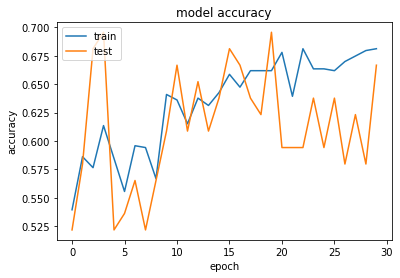

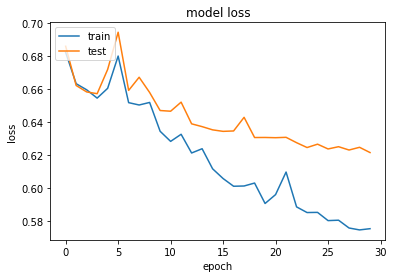

In [ ]:
plot_graphs(audhistory1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(y_test_aud, axis=1), np.argmax(y_pred_aud1, axis=1))

0.6666666666666666

In [ ]:
audmodel2 = tf.keras.models.Sequential()
audmodel2.add(tf.keras.layers.Dense(64, input_shape=(283,), activation="relu"))
audmodel2.add(tf.keras.layers.Dense(32, activation="relu"))
audmodel2.add(tf.keras.layers.Dense(16, activation="relu"))
audmodel2.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
audmodel2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
audhistory2 = audmodel2.fit(X_train_aud, y_train_aud, epochs=30, callbacks=[callback], validation_data=(X_test_aud, y_test_aud), verbose=2)

Epoch 1/30
20/20 - 1s - loss: 0.6909 - accuracy: 0.5217 - val_loss: 0.6846 - val_accuracy: 0.5072 - lr: 0.0010 - 709ms/epoch - 35ms/step
Epoch 2/30
20/20 - 0s - loss: 0.6815 - accuracy: 0.5717 - val_loss: 0.6745 - val_accuracy: 0.5507 - lr: 0.0010 - 61ms/epoch - 3ms/step
Epoch 3/30
20/20 - 0s - loss: 0.6784 - accuracy: 0.5539 - val_loss: 0.6681 - val_accuracy: 0.5797 - lr: 0.0010 - 66ms/epoch - 3ms/step
Epoch 4/30
20/20 - 0s - loss: 0.6744 - accuracy: 0.5813 - val_loss: 0.6682 - val_accuracy: 0.5942 - lr: 0.0010 - 68ms/epoch - 3ms/step
Epoch 5/30
20/20 - 0s - loss: 0.6648 - accuracy: 0.6039 - val_loss: 0.6718 - val_accuracy: 0.5217 - lr: 0.0010 - 79ms/epoch - 4ms/step
Epoch 6/30
20/20 - 0s - loss: 0.6614 - accuracy: 0.5926 - val_loss: 0.6646 - val_accuracy: 0.5652 - lr: 0.0010 - 83ms/epoch - 4ms/step
Epoch 7/30
20/20 - 0s - loss: 0.6562 - accuracy: 0.5974 - val_loss: 0.6605 - val_accuracy: 0.5797 - lr: 0.0010 - 76ms/epoch - 4ms/step
Epoch 8/30
20/20 - 0s - loss: 0.6533 - accuracy: 0.63

In [ ]:
y_pred_aud2 = audmodel2.predict(X_test_aud)
rep = classification_report(np.argmax(y_test_aud, axis=1),np.argmax(y_pred_aud2, axis=1))
print(rep)

3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.58      0.76      0.66        33
           1       0.69      0.50      0.58        36

    accuracy                           0.62        69
   macro avg       0.64      0.63      0.62        69
weighted avg       0.64      0.62      0.62        69



In [ ]:
accuracy_score(np.argmax(y_test_aud, axis=1), np.argmax(y_pred_aud2, axis=1))

0.6231884057971014

In [ ]:
audmodel2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                18176     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,818
Trainable params: 20,818
Non-trainable params: 0
_________________________________________________________________


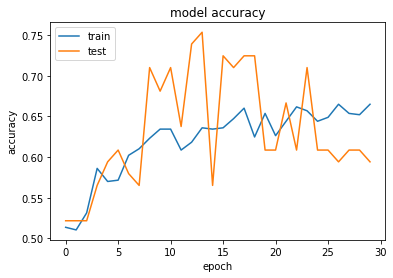

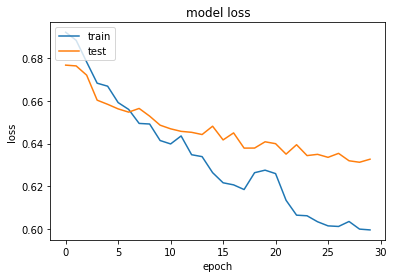

In [ ]:
plot_graphs(audhistory2)

## Text

In [ ]:
import pickle
dbfile = open('/content/drive/MyDrive/Pickle_Data/text_bert_embeddings.pkl', 'rb')     
X = pickle.load(dbfile)


In [ ]:
X = np.asarray(X)

In [ ]:
y_oh.shape

(690, 2)

In [ ]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(X,y_oh, test_size=0.10, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 
X_train_txt = sc.fit_transform(X_train_txt)
X_test_txt = sc.transform(X_test_txt)

In [ ]:
X_train_txt.shape

(621, 768)

In [ ]:
tf.keras.backend.clear_session()
txtmodel1 = tf.keras.models.Sequential()
txtmodel1.add(tf.keras.layers.Dense(512, input_shape=(768,), activation="relu"))
txtmodel1.add(tf.keras.layers.Dense(256, activation="relu"))
txtmodel1.add(tf.keras.layers.Dense(128, activation="relu"))
txtmodel1.add(tf.keras.layers.Dense(32, activation="relu"))
txtmodel1.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
txtmodel1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
txthistory1 = txtmodel1.fit(X_train_txt, y_train_txt, epochs=30, callbacks=[callback], validation_data=(X_test_txt, y_test_txt), verbose=2)

Epoch 1/30
20/20 - 1s - loss: 0.7651 - accuracy: 0.4895 - val_loss: 0.7099 - val_accuracy: 0.5072 - lr: 0.0010 - 832ms/epoch - 42ms/step
Epoch 2/30
20/20 - 0s - loss: 0.5656 - accuracy: 0.7311 - val_loss: 0.7900 - val_accuracy: 0.5217 - lr: 0.0010 - 191ms/epoch - 10ms/step
Epoch 3/30
20/20 - 0s - loss: 0.3674 - accuracy: 0.8502 - val_loss: 0.9885 - val_accuracy: 0.4928 - lr: 0.0010 - 171ms/epoch - 9ms/step
Epoch 4/30
20/20 - 0s - loss: 0.2265 - accuracy: 0.9291 - val_loss: 1.0890 - val_accuracy: 0.5652 - lr: 0.0010 - 170ms/epoch - 8ms/step
Epoch 5/30
20/20 - 0s - loss: 0.1434 - accuracy: 0.9533 - val_loss: 1.1917 - val_accuracy: 0.5217 - lr: 0.0010 - 166ms/epoch - 8ms/step
Epoch 6/30
20/20 - 0s - loss: 0.0826 - accuracy: 0.9758 - val_loss: 1.4482 - val_accuracy: 0.5072 - lr: 0.0010 - 177ms/epoch - 9ms/step
Epoch 7/30
20/20 - 0s - loss: 0.0511 - accuracy: 0.9839 - val_loss: 1.3932 - val_accuracy: 0.5797 - lr: 0.0010 - 190ms/epoch - 10ms/step
Epoch 8/30
20/20 - 0s - loss: 0.0423 - accura

In [ ]:
y_pred_txt1 = txtmodel1.predict(X_test_txt)
rep = classification_report(np.argmax(y_test_txt, axis=1),np.argmax(y_pred_txt1, axis=1))
print(rep)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        33
           1       0.54      0.58      0.56        36

    accuracy                           0.52        69
   macro avg       0.52      0.52      0.52        69
weighted avg       0.52      0.52      0.52        69



In [ ]:
accuracy_score(np.argmax(y_test_txt, axis=1),np.argmax(y_pred_txt1, axis=1))

0.5217391304347826

In [ ]:
roc_auc_score(np.argmax(y_test_txt, axis=1),np.argmax(y_pred_txt1, axis=1))

0.518939393939394

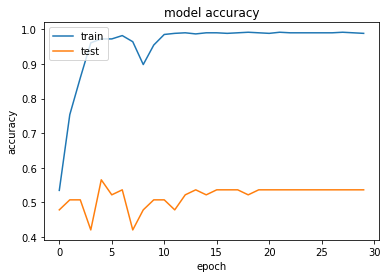

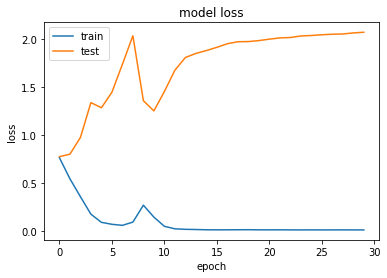

In [ ]:
plot_graphs(txthistory1)

In [ ]:
tf.keras.backend.clear_session()
txtmodel2 = tf.keras.models.Sequential()
txtmodel2.add(tf.keras.layers.Dense(128, input_shape=(768,), activation="relu"))
txtmodel2.add(tf.keras.layers.Dense(64, activation="relu"))
txtmodel2.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
txtmodel2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
txthistory2 = txtmodel2.fit(X_train_txt, y_train_txt, epochs=10, callbacks=[callback], validation_data=(X_test_txt, y_test_txt), verbose=2)

Epoch 1/10
20/20 - 1s - loss: 0.8715 - accuracy: 0.5121 - val_loss: 0.8793 - val_accuracy: 0.5362 - lr: 0.0010 - 660ms/epoch - 33ms/step
Epoch 2/10
20/20 - 0s - loss: 0.4727 - accuracy: 0.7649 - val_loss: 0.9302 - val_accuracy: 0.5362 - lr: 0.0010 - 72ms/epoch - 4ms/step
Epoch 3/10
20/20 - 0s - loss: 0.2917 - accuracy: 0.9324 - val_loss: 0.8250 - val_accuracy: 0.5217 - lr: 0.0010 - 88ms/epoch - 4ms/step
Epoch 4/10
20/20 - 0s - loss: 0.1870 - accuracy: 0.9710 - val_loss: 0.9221 - val_accuracy: 0.4493 - lr: 0.0010 - 91ms/epoch - 5ms/step
Epoch 5/10
20/20 - 0s - loss: 0.1321 - accuracy: 0.9855 - val_loss: 0.9925 - val_accuracy: 0.5217 - lr: 0.0010 - 74ms/epoch - 4ms/step
Epoch 6/10
20/20 - 0s - loss: 0.1078 - accuracy: 0.9855 - val_loss: 1.0057 - val_accuracy: 0.5217 - lr: 0.0010 - 73ms/epoch - 4ms/step
Epoch 7/10
20/20 - 0s - loss: 0.0739 - accuracy: 0.9887 - val_loss: 1.0820 - val_accuracy: 0.5072 - lr: 0.0010 - 84ms/epoch - 4ms/step
Epoch 8/10
20/20 - 0s - loss: 0.0577 - accuracy: 0.99

In [ ]:
y_pred_txt2 = txtmodel2.predict(X_test_txt)
rep = classification_report(np.argmax(y_test_txt, axis=1),np.argmax(y_pred_txt2, axis=1))
print(rep)

3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.50      0.55      0.52        33
           1       0.55      0.50      0.52        36

    accuracy                           0.52        69
   macro avg       0.52      0.52      0.52        69
weighted avg       0.52      0.52      0.52        69



In [ ]:
accuracy_score(np.argmax(y_test_txt, axis=1),np.argmax(y_pred_txt2, axis=1))

0.5217391304347826

In [ ]:
roc_auc_score(np.argmax(y_test_txt, axis=1),np.argmax(y_pred_txt2, axis=1))

0.5227272727272727

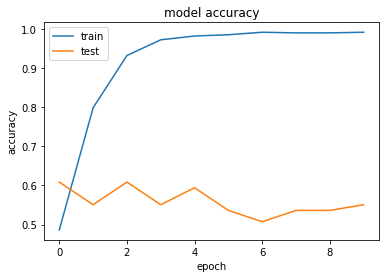

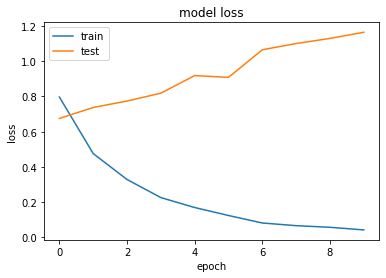

In [ ]:
plot_graphs(txthistory2)

In [ ]:
txtmodel2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 106,818
Trainable params: 106,818
Non-trainable params: 0
_________________________________________________________________


# Combine all the features

In [ ]:
video_file = open('/content/drive/MyDrive/Pickle_Data/video_features.pkl', 'rb')     
vid_db = pickle.load(video_file)

audio_dbfile = open('/content/drive/MyDrive/Pickle_Data/audio_features.pkl', 'rb')     
audio_db = pickle.load(audio_dbfile)

text_db = open('/content/drive/MyDrive/Pickle_Data/text_bert_embeddings.pkl', 'rb')     
X_text = pickle.load(text_db)


label_map_file = open('/content/drive/MyDrive/Pickle_Data/label_map.pkl', 'rb')
label_map = pickle.load(label_map_file)


In [ ]:
type(X_text[0])

numpy.ndarray

In [ ]:
x_labels = vid_db.keys()
X = []
y = []

for i,l in enumerate(x_labels):
  vid_feat = vid_db[l]
  aud_feat = audio_db[l]
  text_feat = X_text[i]

  curr_feat = vid_feat
  curr_feat = np.concatenate((curr_feat, aud_feat), axis=0)
  curr_feat = np.concatenate((curr_feat, X_text[i]), axis=0)

  X.append(curr_feat)
  y.append(label_map[l])



In [ ]:
X = np.asarray(X).astype('float32')
y = np.array(y)
y = np.where(y==True, 1, 0)
y_oh = tf.keras.utils.to_categorical(y)

In [ ]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_oh, test_size=0.10, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape

(621, 3099)

In [ ]:
tf.keras.backend.clear_session()
combinedmodel1 = tf.keras.models.Sequential()
combinedmodel1.add(tf.keras.layers.Dense(1024, input_shape=(3099,), activation="relu"))
combinedmodel1.add(tf.keras.layers.Dense(512, activation="relu"))
combinedmodel1.add(tf.keras.layers.Dense(256, activation="relu"))
combinedmodel1.add(tf.keras.layers.Dense(128, activation="relu"))
combinedmodel1.add(tf.keras.layers.Dense(32, activation="relu"))
combinedmodel1.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
combinedmodel1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
combinedhistory1 = combinedmodel1.fit(X_train, y_train, epochs=20, callbacks=[callback], validation_data=(X_test, y_test), verbose=2)

Epoch 1/20
20/20 - 1s - loss: 0.6872 - accuracy: 0.5974 - val_loss: 0.6898 - val_accuracy: 0.7246 - lr: 0.0010 - 1s/epoch - 69ms/step
Epoch 2/20
20/20 - 1s - loss: 0.4161 - accuracy: 0.8341 - val_loss: 0.7091 - val_accuracy: 0.6522 - lr: 0.0010 - 634ms/epoch - 32ms/step
Epoch 3/20
20/20 - 1s - loss: 0.2899 - accuracy: 0.8776 - val_loss: 0.9925 - val_accuracy: 0.6667 - lr: 0.0010 - 607ms/epoch - 30ms/step
Epoch 4/20
20/20 - 1s - loss: 0.2302 - accuracy: 0.9130 - val_loss: 1.1164 - val_accuracy: 0.6812 - lr: 0.0010 - 633ms/epoch - 32ms/step
Epoch 5/20
20/20 - 1s - loss: 0.0934 - accuracy: 0.9646 - val_loss: 1.8680 - val_accuracy: 0.6232 - lr: 0.0010 - 620ms/epoch - 31ms/step
Epoch 6/20
20/20 - 1s - loss: 0.0369 - accuracy: 0.9871 - val_loss: 2.2505 - val_accuracy: 0.5942 - lr: 0.0010 - 638ms/epoch - 32ms/step
Epoch 7/20
20/20 - 1s - loss: 0.0342 - accuracy: 0.9887 - val_loss: 2.4996 - val_accuracy: 0.5942 - lr: 0.0010 - 613ms/epoch - 31ms/step
Epoch 8/20
20/20 - 1s - loss: 0.1142 - accur

In [ ]:
y_pred_combined1 = combinedmodel1.predict(X_test)
rep = classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred_combined1, axis=1))
print(rep)

3/3 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        32
           1       0.74      0.68      0.70        37

    accuracy                           0.70        69
   macro avg       0.70      0.70      0.70        69
weighted avg       0.70      0.70      0.70        69



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred_combined1, axis=1))

0.6956521739130435

In [ ]:
roc_auc_score(np.argmax(y_test, axis=1),np.argmax(y_pred_combined1, axis=1))

0.6972128378378378

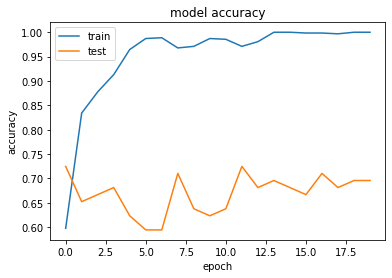

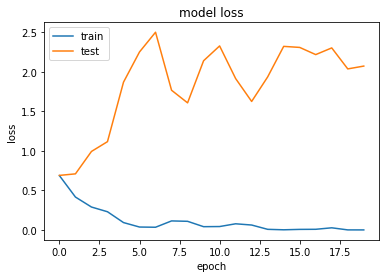

In [ ]:
plot_graphs(combinedhistory1)

In [ ]:
tf.keras.backend.clear_session()
combinedmodel2 = tf.keras.models.Sequential()
combinedmodel2.add(tf.keras.layers.Dense(256, input_shape=(3099,), activation="relu"))
combinedmodel2.add(tf.keras.layers.Dense(128, activation="relu"))
combinedmodel2.add(tf.keras.layers.Dense(32, activation="relu"))
combinedmodel2.add(tf.keras.layers.Dense(2, activation="softmax"))


In [ ]:
combinedmodel2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
combinedhistory2 = combinedmodel2.fit(X_train, y_train, epochs=20, callbacks=[callback], validation_data=(X_test, y_test), verbose=2)

Epoch 1/20
20/20 - 1s - loss: 0.8058 - accuracy: 0.5845 - val_loss: 0.7105 - val_accuracy: 0.5942 - lr: 0.0010 - 830ms/epoch - 42ms/step
Epoch 2/20
20/20 - 0s - loss: 0.3320 - accuracy: 0.8808 - val_loss: 0.7686 - val_accuracy: 0.6667 - lr: 0.0010 - 182ms/epoch - 9ms/step
Epoch 3/20
20/20 - 0s - loss: 0.1410 - accuracy: 0.9646 - val_loss: 0.8684 - val_accuracy: 0.6522 - lr: 0.0010 - 187ms/epoch - 9ms/step
Epoch 4/20
20/20 - 0s - loss: 0.0493 - accuracy: 0.9968 - val_loss: 0.9757 - val_accuracy: 0.6522 - lr: 0.0010 - 188ms/epoch - 9ms/step
Epoch 5/20
20/20 - 0s - loss: 0.0188 - accuracy: 1.0000 - val_loss: 1.0718 - val_accuracy: 0.6667 - lr: 0.0010 - 182ms/epoch - 9ms/step
Epoch 6/20
20/20 - 0s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1483 - val_accuracy: 0.6522 - lr: 0.0010 - 184ms/epoch - 9ms/step
Epoch 7/20
20/20 - 0s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.1797 - val_accuracy: 0.6377 - lr: 0.0010 - 185ms/epoch - 9ms/step
Epoch 8/20
20/20 - 0s - loss: 0.0026 - accuracy

In [ ]:
y_pred_combined2 = combinedmodel2.predict(X_test)
rep = classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred_combined2, axis=1))
print(rep)

3/3 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        32
           1       0.71      0.65      0.68        37

    accuracy                           0.67        69
   macro avg       0.67      0.67      0.67        69
weighted avg       0.67      0.67      0.67        69



In [ ]:
accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred_combined2, axis=1))

0.6666666666666666

In [ ]:
roc_auc_score(np.argmax(y_test, axis=1),np.argmax(y_pred_combined2, axis=1))

0.6680743243243243

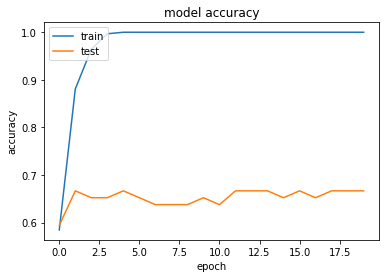

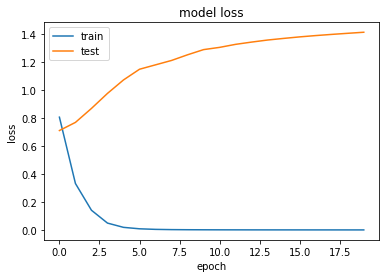

In [ ]:
plot_graphs(combinedhistory2)

In [ ]:
combinedmodel2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               793600    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 830,690
Trainable params: 830,690
Non-trainable params: 0
_________________________________________________________________
